# GNN Explainer Example
This is modified version of `https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gnn_explainer.py`

## Model: 2 Layer GCN (No linear layer)

In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer

dataset = 'Cora'
path = "~/data/Planetoid/"
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

In [2]:
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:3d}, loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step()

Epoch:  10, loss: 1.8764
Epoch:  20, loss: 1.7480
Epoch:  30, loss: 1.5832
Epoch:  40, loss: 1.4001
Epoch:  50, loss: 1.1543
Epoch:  60, loss: 0.9878
Epoch:  70, loss: 0.8368
Epoch:  80, loss: 0.7492
Epoch:  90, loss: 0.6558
Epoch: 100, loss: 0.5366
Epoch: 110, loss: 0.5131
Epoch: 120, loss: 0.4334
Epoch: 130, loss: 0.4359
Epoch: 140, loss: 0.4703
Epoch: 150, loss: 0.3990
Epoch: 160, loss: 0.3920
Epoch: 170, loss: 0.3878
Epoch: 180, loss: 0.3037
Epoch: 190, loss: 0.3417
Epoch: 200, loss: 0.3200


In [3]:
def test():
      model.eval()
      out = model(x, edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

print(f"Test accuracy: {test()*100:.2f}")

Test accuracy: 81.20


### GNNExplainer Training:

- It takes a model and a node id to explain.
- It learns edge_masks and feature masks
- edge_mask shape is same with number of edges
- It focuses k-hop neighbors. It can be specified as a parameter. If not specified, uses number of GNN layers as k.

Explain node 10: 100%|██████████| 200/200 [00:01<00:00, 188.69it/s]


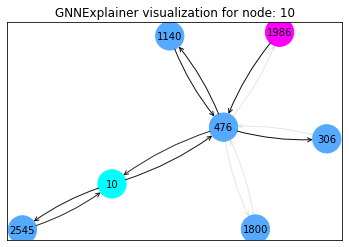

In [4]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.title(f'GNNExplainer visualization for node: {node_idx}')
plt.show()

#### Visualization without GNN Explainer

In [5]:
from torch_geometric.utils import to_networkx
import networkx as nx

# a helper function to find k-hop neighbors
def knbrs(G, start, k):
    nbrs = set([start])
    for l in range(k):
        nbrs = set((nbr for n in nbrs for nbr in G[n])).union(nbrs)
    return nbrs

neighbors: [1986, 1800, 10, 2545, 306, 1140, 476]


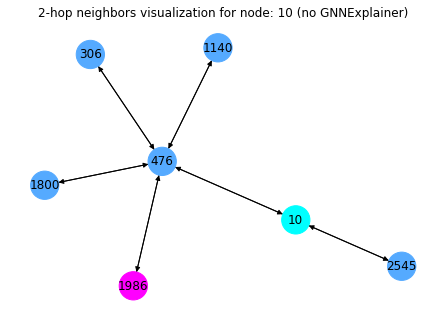

In [6]:
G=to_networkx(data)
neighbors = list(knbrs(G, start=node_idx, k=2))
print('neighbors:', neighbors)
H = nx.subgraph(G, neighbors)
nx.draw(H, pos=nx.spring_layout(H), nodelist=neighbors, with_labels=True, node_color=data.y[neighbors].cpu().numpy(),node_size=800, cmap='cool')
plt.title(f'2-hop neighbors visualization for node: {node_idx} (no GNNExplainer)')
plt.show()

#### Another Example:

Explain node 50: 100%|██████████| 200/200 [00:01<00:00, 183.95it/s]


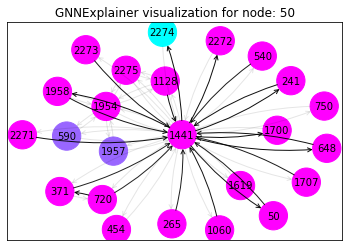

In [7]:
node_idx = 50
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.title(f'GNNExplainer visualization for node: {node_idx}')
plt.show()

neighbors: [454, 648, 265, 590, 720, 1619, 540, 2271, 2272, 1441, 1954, 2273, 1060, 1700, 1957, 1958, 2274, 2275, 1128, 1707, 750, 241, 50, 371]


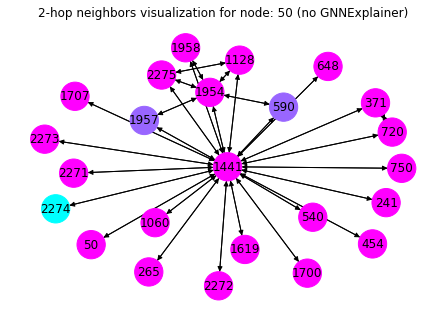

In [8]:
G=to_networkx(data)
neighbors = list(knbrs(G, start=node_idx, k=2))
print('neighbors:', neighbors)
H = nx.subgraph(G, neighbors)
nx.draw(H, pos=nx.spring_layout(H), nodelist=neighbors, with_labels=True, node_color=data.y[neighbors].cpu().numpy(),node_size=800, cmap='cool')
plt.title(f'2-hop neighbors visualization for node: {node_idx} (no GNNExplainer)')
plt.show()